In [1]:
# You only need to run this once per machine
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U datasets scipy ipywidgets matplotlib

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

/home/chuning/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load Dataset

In [3]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='/home/chuning/Downloads/llama/test/new_train_data.json', split='train')  
eval_dataset = load_dataset('json', data_files='/home/chuning/Downloads/llama/test/new_test_data.json', split='train')

In [4]:
train_dataset[0]

{'id': '10696',
 'skills': ['programming',
  'nltk',
  'keras',
  'tensorflow',
  'gensim',
  'xgboost',
  'spark',
  'presto',
  'big data',
  'linkedin',
  'textblob',
  'cloud',
  'mxnet',
  'red',
  'spacy',
  'lightgbm',
  'deep learning',
  'hbase',
  'hadoop',
  'tableau',
  'gcp',
  'pytorch',
  'ml',
  'aws',
  'pig',
  'nlp',
  'machine learning',
  'docker',
  'automation'],
 'not_skills': ['classification',
  'apache',
  'numpy',
  'sql',
  'clustering',
  'matlab',
  'data visualization',
  'computer science',
  'scikit-learn',
  'ai',
  'svm',
  'natural language processing',
  'python',
  'gpu',
  'prediction',
  'java',
  'pandas',
  'data analysis'],
 'text': "Description\n\nSmartNews is a leading mobile app of news aggregation services. It analyzes millions of articles to deliver most engaging information with high quality in near-real time fashion to millions of users around the world. Our AI Foundation team is responsible to research and develop world-class AI algor

### Formatting prompts


```python
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text
```

In [5]:
# def formatting_func(example):
#     text = f"### The job description: {example['text']}\n ### The skills: {example['skills']}"
#     return text

In [6]:
def formatting_func(example):
    text = f"### Job Description: {example['text']}\n### Skills: {', '.join(example['skills'])}\n### Not Skills: {', '.join(example['not_skills'])}"
    return text


### 2. Load Base Model

Let's now load Llama 2 13B - `meta-llama/Llama-2-13b-hf` - using 4 or 8-bit quantization!

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


base_model_id = "meta-llama/Llama-2-13b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)




Loading checkpoint shards:   0%|          | 0/3 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# import torch


# base_model_id = "meta-llama/Llama-2-13b-hf"

# # 使用8-bit量化配置
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=False, 
#     bnb_4bit_compute_dtype=torch.float32  
# )
# model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config).to("cuda")


### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

max_length = 1024
def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result


# def generate_and_tokenize_prompt(prompt):
#     # Tokenize the input
#     tokenized_text = tokenizer(
#         formatting_func(prompt),
#         #prompt['text'],
#         truncation=True,
#         max_length=max_length,
#         padding="max_length",
#     )

#     # Initialize labels with 0 (neither skill nor not-skill)
#     labels = [0] * len(tokenized_text['input_ids'])

#     # Update labels for skills (1) and not-skills (2)
#     for i, token_id in enumerate(tokenized_text['input_ids']):
#         token = tokenizer.decode([token_id])
#         if any(skill in prompt['text'] for skill in prompt['skills']):
#             labels[i] = 1
#         elif any(not_skill in prompt['text'] for not_skill in prompt['not_skills']):
#             labels[i] = 2

#     tokenized_text["labels"] = labels
#     return tokenized_text
# def generate_and_tokenize_prompt(prompt):
#     # Tokenize the input text
#     tokenized_text = tokenizer(
#         formatting_func(prompt),
#         #prompt['text'],
#         truncation=True,
#         max_length=max_length,
#         padding="max_length",
#     )

#     # Initialize labels with 0 (neither skill nor not-skill)
#     labels = [-100] * len(tokenized_text['input_ids'])

#     # Process each token to determine if it is a part of skills or not-skills
#     for i, token_id in enumerate(tokenized_text['input_ids']):
#         token = tokenizer.decode([token_id], clean_up_tokenization_spaces=False)
#         if token.strip() and any(token in skill for skill in prompt['skills']):
#             labels[i] = 1
#         elif token.strip() and any(token in not_skill for not_skill in prompt['not_skills']):
#             labels[i] = 2

#     tokenized_text["labels"] = labels
#     return tokenized_text



In [ ]:
# def generate_and_tokenize_prompt(prompt):
#     # Tokenize the input text
#     tokenized_text = tokenizer(
#         #prompt['text'],
#         formatting_func(prompt),
#         truncation=True,
#         max_length=max_length,
#         padding="max_length",
#     )

#     # Initialize labels with -100 (ignore index)
#     labels = [-100] * len(tokenized_text['input_ids'])

#     # Function to find indices of a sub-list in a list
#     def find_sub_list(sub_list, main_list):
#         results = []
#         sll = len(sub_list)
#         for ind in (i for i, e in enumerate(main_list) if e == sub_list[0]):
#             if main_list[ind:ind+sll] == sub_list:
#                 results.append((ind, ind+sll-1))
#         return results

#     # Assign labels for skills
#     for skill in prompt['skills']:
#         skill_tokens = tokenizer.encode(skill, add_special_tokens=False)
#         for start, end in find_sub_list(skill_tokens, tokenized_text['input_ids']):
#             labels[start:end+1] = [1] * (end - start + 1)

#     # Assign labels for not-skills
#     for not_skill in prompt['not_skills']:
#         not_skill_tokens = tokenizer.encode(not_skill, add_special_tokens=False)
#         for start, end in find_sub_list(not_skill_tokens, tokenized_text['input_ids']):
#             labels[start:end+1] = [2] * (end - start + 1)

#     tokenized_text["labels"] = labels
#     return tokenized_text


In [ ]:
# def generate_and_tokenize_prompt(prompt):
#     # Tokenize the job description text
#     formatted_text = formatting_func(prompt)
#     tokenized_text = tokenizer(
#         formatted_text,
#         #prompt['text']
#         truncation=True,
#         max_length=max_length,
#         padding='max_length', 
#         return_tensors="pt",
#     )

#     # Start labels with -100 to ignore these tokens during loss computation
#     labels = [-100] * len(tokenized_text['input_ids'])

#     # Tokenize and label skills
#     for skill in prompt['skills']:
#         skill_tokens = tokenizer.encode(skill, add_special_tokens=False)
#         labels.extend([1] * len(skill_tokens))  # Label for skill
#         tokenized_text['input_ids'] = torch.cat([tokenized_text['input_ids'], 
#                                                  torch.tensor([skill_tokens], dtype=torch.long)], dim=1)

#     # Tokenize and label not-skills
#     for not_skill in prompt['not_skills']:
#         not_skill_tokens = tokenizer.encode(not_skill, add_special_tokens=False)
#         labels.extend([2] * len(not_skill_tokens))  # Label for not-skill
#         tokenized_text['input_ids'] = torch.cat([tokenized_text['input_ids'], 
#                                                  torch.tensor([not_skill_tokens], dtype=torch.long)], dim=1)

#     # Add padding manually if necessary
#     if len(tokenized_text['input_ids'][0]) < max_length:
#         padding_length = max_length - len(tokenized_text['input_ids'][0])
#         tokenized_text['input_ids'] = torch.cat([tokenized_text['input_ids'], 
#                                                  torch.tensor([[tokenizer.pad_token_id] * padding_length], dtype=torch.long)], dim=1)
#         labels.extend([-100] * padding_length)  # Pad labels with -100

#     # tokenized_text['labels'] = torch.tensor([labels], dtype=torch.long)
#     tokenized_text['labels'] = torch.tensor([labels], dtype=torch.long)
#     #tokenized_text["labels"] = tokenized_text["input_ids"].copy()
#     return tokenized_text


In [ ]:
# def generate_and_tokenize_prompt(prompt):
#     # Tokenize the job description text
#     formatted_text = formatting_func(prompt)
#     tokenized_text = tokenizer(
#         formatted_text,
#         truncation=True,
#         max_length=max_length,
#         padding='max_length', 
#         return_tensors="pt",
#     )

#     # Initialize labels with -100 to ignore these tokens during loss computation
#     labels = [-100] * max_length

#     # Assign labels for skills and not-skills
#     all_skills = prompt['skills'] + prompt['not_skills']
#     for skill in all_skills:
#         skill_label = 1 if skill in prompt['skills'] else 2
#         skill_tokens = tokenizer.encode(skill, add_special_tokens=False)
#         for i, token_id in enumerate(tokenized_text['input_ids'][0]):
#             if token_id in skill_tokens:
#                 labels[i] = skill_label

#     # Convert labels to a tensor
#     tokenized_text['labels'] = torch.tensor([labels])

#     return tokenized_text


In [ ]:
# def generate_and_tokenize_prompt(prompt):
#     # Tokenize the job description text
#     formatted_text = formatting_func(prompt)
#     tokenized_text = tokenizer(
#         formatted_text,
#         truncation=True,
#         max_length=max_length,
#         padding='max_length', 
#         return_tensors="pt",
#     )

#     # Initialize labels with -100 to ignore these tokens during loss computation
#     labels = [-100] * max_length

#     # Process each skill and not-skill
#     for skill in prompt['skills']:
#         labels = label_tokens(tokenized_text, skill, 1, labels)
#     for not_skill in prompt['not_skills']:
#         labels = label_tokens(tokenized_text, not_skill, 2, labels)

#     # Convert labels to a tensor
#     tokenized_text['labels'] = torch.tensor([labels])
#     return tokenized_text

# def label_tokens(tokenized_text, phrase, label, labels):
#     # Tokenize the phrase without special tokens
#     phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)
#     # Find start index of phrase tokens in input_ids
#     for i in range(len(tokenized_text['input_ids'][0]) - len(phrase_tokens) + 1):
#         if tokenized_text['input_ids'][0][i:i+len(phrase_tokens)].tolist() == phrase_tokens:
#             # Assign label to each token in the phrase
#             for j in range(i, i+len(phrase_tokens)):
#                 labels[j] = label
#     return labels


In [ ]:
# def generate_and_tokenize_prompt(prompt):
#     # Tokenize the job description text
#     formatted_text = formatting_func(prompt)
#     tokenized_text = tokenizer(
#         formatted_text,
#         truncation=True,
#         max_length=max_length,
#         padding='max_length',
#         return_tensors="pt"  # Ensure this is set
#     )

#     # Initialize labels with -100 for each token
#     labels = [-100] * max_length

#     # Assign labels for skills and not-skills
#     all_skills = prompt['skills'] + prompt['not_skills']
#     for skill in all_skills:
#         skill_label = 1 if skill in prompt['skills'] else 2
#         skill_tokens = tokenizer.encode(skill, add_special_tokens=False)
#         for i, token_id in enumerate(tokenized_text['input_ids'][0]):
#             if token_id in skill_tokens:
#                 labels[i] = skill_label

#     # Convert labels to a tensor
#     tokenized_text['labels'] = torch.tensor(labels).unsqueeze(0)  # Add batch dimension

#     return tokenized_text


Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [ ]:
for i, batch in enumerate(tokenized_train_dataset):
    print(f"Batch {i}:")
    if isinstance(batch, dict):
        for key in batch:
            print(f"{key}: type={type(batch[key])}, shape={getattr(batch[key], 'shape', 'N/A')}")
    else:
        print(f"Unexpected format: type={type(batch)}")
    if i >= 1:  # Check the first couple of batches
        break


Batch 0:
id: type=<class 'str'>, shape=N/A
skills: type=<class 'list'>, shape=N/A
not_skills: type=<class 'list'>, shape=N/A
text: type=<class 'str'>, shape=N/A
input_ids: type=<class 'list'>, shape=N/A
attention_mask: type=<class 'list'>, shape=N/A
labels: type=<class 'list'>, shape=N/A
Batch 1:
id: type=<class 'str'>, shape=N/A
skills: type=<class 'list'>, shape=N/A
not_skills: type=<class 'list'>, shape=N/A
text: type=<class 'str'>, shape=N/A
input_ids: type=<class 'list'>, shape=N/A
attention_mask: type=<class 'list'>, shape=N/A
labels: type=<class 'list'>, shape=N/A


In [ ]:
tokenized_train_dataset[0]

{'id': '10696',
 'skills': ['programming',
  'nltk',
  'keras',
  'tensorflow',
  'gensim',
  'xgboost',
  'spark',
  'presto',
  'big data',
  'linkedin',
  'textblob',
  'cloud',
  'mxnet',
  'red',
  'spacy',
  'lightgbm',
  'deep learning',
  'hbase',
  'hadoop',
  'tableau',
  'gcp',
  'pytorch',
  'ml',
  'aws',
  'pig',
  'nlp',
  'machine learning',
  'docker',
  'automation'],
 'not_skills': ['classification',
  'apache',
  'numpy',
  'sql',
  'clustering',
  'matlab',
  'data visualization',
  'computer science',
  'scikit-learn',
  'ai',
  'svm',
  'natural language processing',
  'python',
  'gpu',
  'prediction',
  'java',
  'pandas',
  'data analysis'],
 'text': "Description\n\nSmartNews is a leading mobile app of news aggregation services. It analyzes millions of articles to deliver most engaging information with high quality in near-real time fashion to millions of users around the world. Our AI Foundation team is responsible to research and develop world-class AI algor

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

2217


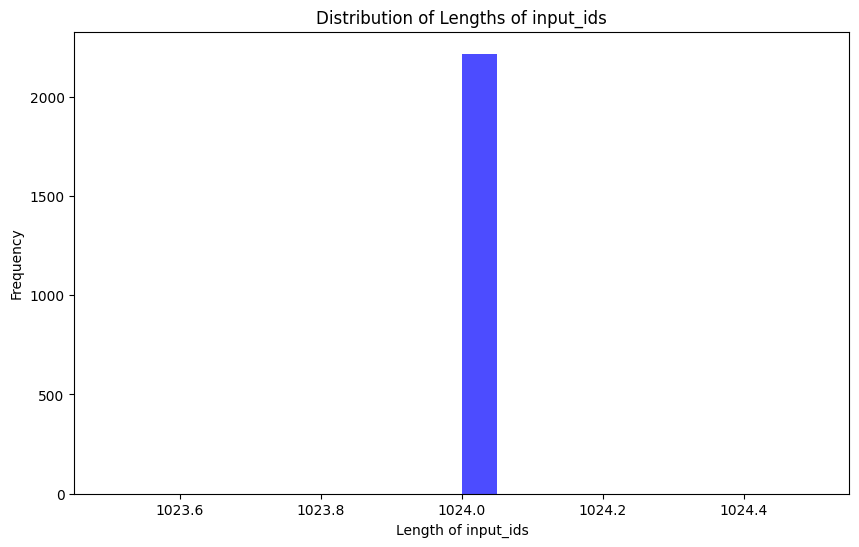

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs. 

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [ ]:
# max_length = 1024
# def generate_and_tokenize_prompt(prompt):
#     result = tokenizer(
#         formatting_func(prompt),
#         truncation=True,
#         max_length=max_length,
#         padding="max_length",
#     )
#     result["labels"] = result["input_ids"].copy()
#     return result

In [ ]:
# tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
# tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [ ]:
print(tokenized_train_dataset[1])

{'id': '20315', 'skills': ['leadership', 'php', 'tensorflow', 'sql', 'c++', 'matlab', 'seaborn', 'event management', 'matplotlib', 'git', 'powerpoint', 'riak', 'c sharp', 'scikit-learn', 'excel', 'rstudio', 'jdbc', 'libsvm', 'writing', 'pytorch', 'javascript', 'python', 'latex', 'node.js', 'c#', 'jupyter notebook'], 'not_skills': ['keras', 'opencv', 'numpy', 'computer vision', 'anomaly detection', 'solidworks', 'cntk', 'adobe illustrator', 'pca', 'horovod', 'labview', 'maple', 'deep learning', 'selenium', 'svm', 'swift', 'cnn', 'adobe photoshop', 'igor pro', 'pandas', 'nlp', 'tensorfelow'], 'text': 'Located in the Bay Area, Geneus Tech Inc. is a subsidiary/branch research center of its parent company in China, which is dedicated to the development and commercial application of 4th generation (nanopore-based) gene sequencing solutions, including devices, IC-MEMS chips, reagents, algorithms and software systems. The core technology platform is based on the detection and processing of cha

Now all the samples should be the same length, `max_length`.

In [ ]:
# eval_prompt = f""" ### The job description: {tokenized_train_dataset[1]['text']} 

# ### The skills:


# """


In [ ]:
eval_prompt = f""" ### The job description: {tokenized_train_dataset[1]['text']} 

### The skills:


"""

In [ ]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 ### The job description: Located in the Bay Area, Geneus Tech Inc. is a subsidiary/branch research center of its parent company in China, which is dedicated to the development and commercial application of 4th generation (nanopore-based) gene sequencing solutions, including devices, IC-MEMS chips, reagents, algorithms and software systems. The core technology platform is based on the detection and processing of characteristic current signals generated by the interaction between nanopore biosensors and nucleic acid bases. Thus, high-throughput sequencing of nucleic acids can be achieved at the single-molecule level through a highly integrated chip system.
This cutting-edge technology is highly expected to revolutionize the current sequencing filed by providing results with significantly higher data quality and lower cost as well as much higher convenience and timeliness. The parent company in China just hit a major milestone to launch the alpha version of our first generation product, 

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        # "v_proj",
        # "o_proj",
        # "gate_proj",
        # "up_proj",
        # "down_proj",
        # "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 26214400 || all params: 6698193920 || trainable%: 0.391365199531279


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(
       


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [ ]:
#!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "IPG-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liuchuning831. Use `wandb login --relogin` to force relogin


### 5. Run Training!

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
# from torch import nn
# from transformers import Trainer


# class CustomLoss(nn.Module):
#     def __init__(self, weight_skills=1.5, weight_not_skills=0.5):
#         super(CustomLoss, self).__init__()
#         self.weight_skills = weight_skills
#         self.weight_not_skills = weight_not_skills
#         self.loss_fct = nn.CrossEntropyLoss(reduction='none')

#     def forward(self, logits, labels):
#         # Flatten logits and labels for loss computation
#         batch_size, sequence_length, num_labels = logits.shape
#         logits_flat = logits.view(-1, num_labels)
#         labels_flat = labels.view(-1)

#         # Compute Cross-Entropy Loss without reduction
#         loss = self.loss_fct(logits_flat, labels_flat)

#         # Reshape loss back to (batch_size, sequence_length)
#         loss = loss.view(batch_size, sequence_length)

#         # Apply fixed weights to the loss
#         skills_mask = labels == 1
#         not_skills_mask = labels == 2
#         loss[skills_mask] *= self.weight_skills
#         loss[not_skills_mask] *= self.weight_not_skills

#         # Average the loss
#         return loss.mean()



In [ ]:
# from torch import nn
# from transformers import Trainer
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.get("logits")

#         # Cross-Entropy Loss
#         loss_fct = nn.CrossEntropyLoss()
#         batch_size, sequence_length, num_labels = logits.shape
#         standard_loss = loss_fct(logits.view(batch_size * sequence_length, num_labels), labels.view(-1))

#         # Custom logic for 'NotSkills'
#         weight_not_skills = 2.0  # Consider adjusting based on class distribution
#         not_skills_mask = labels == 0
#         not_skills_loss = 1
#         if not_skills_mask.any():
#             not_skills_loss = loss_fct(logits[not_skills_mask], labels[not_skills_mask])

#         # Combining losses
#         total_loss = standard_loss + weight_not_skills * not_skills_loss

#         return (total_loss, outputs) if return_outputs else total_loss

In [ ]:

# from transformers import Trainer
# import torch

# class CustomTrainer(Trainer):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         # Initialize the custom loss function with desired weights
#         self.custom_loss_fct = CustomLoss(weight_skills=2.0, weight_not_skills=0.0)

#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         #print(inputs)
#         #print(labels)
#         outputs = model(**inputs)
#         logits = outputs.logits

#         # Call the custom loss function
#         loss = self.custom_loss_fct(logits, labels)

#         return (loss, outputs) if return_outputs else loss



In [ ]:
# import torch
# import torch.nn.functional as F
# from transformers import Trainer

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         # Extract the outputs from the model
#         outputs = model(**inputs)

#         # The first element of model outputs is the logits
#         logits = outputs.logits

#         # Reshape labels to match the size of output
#         labels = inputs["labels"].view(-1)

#         # Reshape logits to match the size of labels
#         logits = logits.view(-1, self.model.config.num_labels)

#         # Compute custom loss: Cross-Entropy Loss
#         # Ignore the index of -100 in labels
#         loss = F.cross_entropy(logits, labels, ignore_index=-100)

#         return (loss, outputs) if return_outputs else loss


In [ ]:
import torch
import torch.nn.functional as F
from transformers import Trainer

class Trainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
            # """
            # How the loss is computed by Trainer. By default, all models return the loss in the first element.

            # Subclass and override for custom behavior.
            # """
            # if self.label_smoother is not None and "labels" in inputs:
            #     labels = inputs.pop("labels")
            # else:
            #     labels = None
            # outputs = model(**inputs)
            # print(inputs)
            # # Save past state if it exists
            # # TODO: this needs to be fixed and made cleaner later.
            # if self.args.past_index >= 0:
            #     self._past = outputs[self.args.past_index]

            # if labels is not None:
            #     unwrapped_model = unwrap_model(model)
            #     if is_peft_available() and isinstance(unwrapped_model, PeftModel):
            #         model_name = unwrapped_model.base_model.model._get_name()
            #     else:
            #         model_name = unwrapped_model._get_name()
            #     if model_name in MODEL_FOR_CAUSAL_LM_MAPPING_NAMES.values():
            #         loss = self.label_smoother(outputs, labels, shift_labels=True)
            #     else:
            #         loss = self.label_smoother(outputs, labels)
            # else:
            #     if isinstance(outputs, dict) and "loss" not in outputs:
            #         raise ValueError(
            #             "The model did not return a loss from the inputs, only the following keys: "
            #             f"{','.join(outputs.keys())}. For reference, the inputs it received are {','.join(inputs.keys())}."
            #         )
            #     # We don't use .loss here since the model may return tuples instead of ModelOutput.
            #     loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

            # return (loss, outputs) if return_outputs else loss
                """
            How the loss is computed by Trainer. By default, all models return the loss in the first element.

            Subclass and override for custom behavior.
            """
                outputs = model(**inputs)
                # Save past state if it exists
                # TODO: this needs to be fixed and made cleaner later.
                if self.args.past_index >= 0:
                    self._past = outputs[self.args.past_index]

                if self.label_smoother is not None and "labels" in inputs:
                    return self.label_smoother(outputs, inputs["labels"])
                else:
                    # We don't use .loss here since the model may return tuples instead of ModelOutput.
                    return outputs["loss"] if isinstance(outputs, dict) else outputs[0]

    # def compute_loss(self, model, inputs, return_outputs=False):
    #     # Extract the outputs from the model
    #     outputs = model(**inputs)
    #     logits = outputs.logits

    #     # Debug: Print shapes before reshaping
    #     print("Original Logits Shape:", logits.shape)
    #     print("Original Labels Shape:", inputs["labels"].shape)

    #     # Flatten the logits and labels
    #     logits = logits.view(-1, self.model.config.num_labels)  # Ensure this is set to 2 for binary classification
    #     labels = inputs["labels"].view(-1)

    #     # Debug: Print shapes after reshaping
    #     print("Reshaped Logits Shape:", logits.shape)
    #     print("Reshaped Labels Shape:", labels.shape)

    #     # Verify that the total number of elements matches
    #     if logits.shape[0] != labels.shape[0]:
    #         raise ValueError(f"Mismatch in total number of elements: logits ({logits.shape[0]}) vs labels ({labels.shape[0]})")

    #     # Compute the loss
    #     loss = F.cross_entropy(logits, labels, ignore_index=-100)
    #     batch_size, sequence_length, num_labels = logits.shape

    #     return (loss, outputs) if return_outputs else loss



In [8]:
print(transformers.__version__)


NameError: name 'transformers' is not defined

In [ ]:
import subprocess
import threading

def log_gpu_memory(log_file_path, interval=60):
    gpu_memory_usage = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader']).decode('utf-8')
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"GPU: {gpu_memory_usage}\n")

    threading.Timer(interval, log_gpu_memory, args=[log_file_path, interval]).start()

# 启动GPU内存监控
log_file_path = 'gpu_memory_log.txt'
log_gpu_memory(log_file_path)


import transformers
from datetime import datetime

project = "IPG-finetune"
base_model_name = "llama2-13b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=4,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        max_steps=3000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=100,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacty of 23.66 GiB of which 448.19 MiB is free. Process 4455 has 287.47 MiB memory in use. Process 12793 has 9.51 GiB memory in use. Including non-PyTorch memory, this process has 12.12 GiB memory in use. Of the allocated memory 10.31 GiB is allocated by PyTorch, and 1.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF